In [7]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from io import BytesIO
from PIL import Image
import requests

def url_to_img(url):
    img = Image.open(BytesIO(requests.get(url).content))
    return img
from keras.preprocessing import image

In [8]:
img = url_to_img("https://earimediaprodweb.azurewebsites.net/Api/v1/Multimedia/92df815c-5ed6-47de-bc4a-7cf41ffc0d73/Rendition/low-res/Content/Public")
img_resized = img.resize((224, 224))

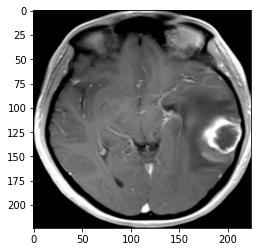

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img_resized)

In [10]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

x = np.array(img_resized)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
print(np.amax(x))
# Note: each Keras Application expects a specific kind of input preprocessing. 
# For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs 
# before passing them to the model. vgg16.preprocess_input will convert the input 
# images from RGB to BGR, then will zero-center each color channel with respect to
# the ImageNet dataset, without scaling.
x = preprocess_input(x)
print(np.amax(x))

(224, 224, 3)
(1, 224, 224, 3)
255
151.061


In [11]:
from keras.models import load_model

model = load_model(".\\brain.h5")

model.summary()


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [12]:
preds = model.predict(x)
print('Predicted:',preds)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Predicted: [[1.1975051e-38 1.0000000e+00]]


In [13]:
preds.shape

(1, 2)

In [14]:
np.argmax(preds[0])

1

In [15]:
model.output.shape # shape??

TensorShape([None, 2])

In [16]:
model.output

<tf.Tensor 'dense_5_1/Softmax:0' shape=(None, 2) dtype=float32>

In [17]:

from keras import backend as K


# This is the entry with highest confidence in the prediction vector
max_class_output = model.output[:, np.argmax(preds[0])] # max_class_output = model.output[:, np.argmax(preds[0])]
print(max_class_output)
# This is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# ------- MATH MAGIC HIDDEN IN KERAS FUNCTIONS ----------
# This is the gradient of the class with highest confidence with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(max_class_output, last_conv_layer.output)[0]
print(grads)

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads)
# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
print(iterate)
# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

print(pooled_grads_value)
print(conv_layer_output_value)

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(pooled_grads.shape[0]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

# ------------ MATH MAGIG OVER -------------------------------

Tensor("strided_slice:0", shape=(None,), dtype=float32)
Tensor("gradients/block5_pool_1/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
Tensor("Mean:0", shape=(512,), dtype=float32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [18]:
heatmap

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

(14, 14)


C:\Users\wibst\AppData\Local\Temp/ipykernel_10652/755976205.py:2: RuntimeWarning: invalid value encountered in true_divide
  heatmap /= np.max(heatmap)


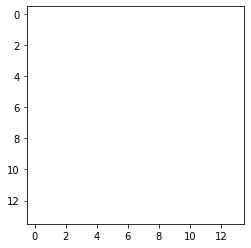

In [19]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
print(heatmap.shape)
plt.imshow(heatmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


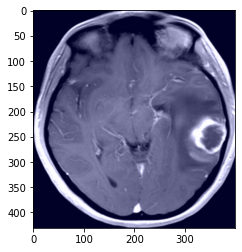

In [20]:
import cv2

# PILLOW -> numpy array
img_numpy = np.array(img) # Will give RGB, but opencv wants BGR

# We resize the heatmap to have the same size as the original image
heatmap_resized = cv2.resize(heatmap, (img_numpy.shape[1], img_numpy.shape[0]))

# We convert the heatmap to values 0-255
heatmap_resized = np.uint8(255 * heatmap_resized)

# We apply the heatmap to the original image
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# 0.3 here is a heatmap intensity factor
superimposed_img = heatmap_resized[:,:,::-1] * 0.3 + img_numpy

plt.imshow(np.rint(superimposed_img).astype(int))

In [21]:
print(superimposed_img)

[[[ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  ...
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]]

 [[ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  ...
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]]

 [[ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  ...
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]]

 ...

 [[ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  ...
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]]

 [[ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  ...
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]]

 [[ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  ...
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]
  [ 1.   1.  39.4]]]


In [22]:
int_img = np.rint(superimposed_img).astype(int)
np.amax(int_img)

293